# 电力窃漏电用户自动识别
## 一、背景与挖掘目标
- 通过用户用电数据信息提取出窃漏电用户的关键特征，构建窃漏电用户的识别模型，自动检查、判断用户是否存在窃漏电行为。  
*数据挖掘建模目标如下：*

- 归纳出窃漏电用户的关键特征，构建且漏电用户的识别模型。
- 利用实时监测数据，调用窃漏电用户识别模型实现实时诊断


## 二、电力行业为什么需要数据挖掘？
|传统的检查方式|不合理之处|
|:-------------------------------:|:--:|
|定期巡检、定期检查电表、用户举报|对人的依赖太高，容错率低 。|
|营销稽查人员、用电检查人员利用计量异常报警功能和电能量数据查询功能开展在线监控，采集异常信息，建立数据分析模型|由于终端误报，存在数据可靠性问题。|

***因此，我们可以看出：***
- 目前存在的分析模型，各输入指标权重是由人定的，这是含有主观臆断的，存在明显缺陷，实施效果不尽如人意。
- 目前的自动化系统可以采集相关信息，通过这些信息提取漏电用户的特征，构建识别模型，就能做到自动检查。

## 三、分析过程和方法

### 1、数据获取
从营销系统和计量自动化系统中抽取如下数据：    

- 从营销系统抽取的数据
    用户基本信息
    违约、窃电处理记录
    计量方法及依据
- 从计量自动化系统采集的数据属性：
    实时负荷
    终端报警
本案例抽取某市5年来所有用户的且漏电用户有关数据和不同用电类别正常用电用户共208个用户的有关数据，同时包含每天是否有窃漏电情况的标识。    

###  2、数据探索
- 分布分析（主要目的是筛选分析对象类别）
查看用电类别切漏电情况，明确哪一些人群、领域窃漏电情况严重（大工业、非工业、居民、农业、商业等）。
- 周期性分析（查看正常用户和非正常用户数据周期变化比对）
正常用电量周期性用量平稳，没有太大波动；窃漏电用户用电量出现明显下降的趋势

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve


In [28]:
df=pd.read_excel('Electric-missing_data.xls',header=None)
df.head()

,0,1,2
0,235.8333,324.0343,478.3231
1,236.2708,325.6379,515.4564
2,238.0521,328.0897,517.0909
3,235.9063,NaN,514.8900
4,236.7604,268.8324,NaN


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 3 columns):
0    19 non-null float64
1    17 non-null float64
2    17 non-null float64
dtypes: float64(3)
memory usage: 584.0 bytes


### 3、数据预处理
- 过滤不可能窃电用户，剔除之
- 过滤特殊时间点数据（节假日，数据不合理是正常的）
- 缺失值处理，使用拉格朗日插值法插值（注意，这里直接删除会造成周期性分析不合理）

拉格朗日插值法：  
确定因变量、自变量；取出缺失值前后5个数据，去除空值，取10个数据组成一组。采用拉格朗日插值公式

In [32]:
from scipy.interpolate import lagrange
#此处缺失较少，且数据集不大，使用拉格朗日插值法进行填充
def missing_fill(col,n,k=5):
    y=col[list(range(n-k,n))+list(range(n+1,n+1+k))]#取出前后五个值
    y=y[y.notnull()]#去除空值
    return lagrange(y.index,list(y))(n)
            #传入该列数据，获取该列非空前后10个数据； 
            #lagrange(x,w) x数据点的x轴，传入的是数据的下标索引；w是传入的数据。
#找出空值用定义的函数来替换
for i in df.columns:
    for j in range(len(df)):#返回ture or false 来判断是否执行
        if df[i].isnull()[j]:#如果是空值就用拉格郎日插值法处理
            df[i][j]=missing_fill(df[i],j,k=5)

D:\Anaconda3\lib\site-packages\pandas\core\series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 3 columns):
0    21 non-null float64
1    21 non-null float64
2    21 non-null float64
dtypes: float64(3)
memory usage: 584.0 bytes


In [35]:
df.to_excel('missing_data_fill.xls', header=None, index=False)

### 4、数据的变换：
基于系统采集到的一些数据，来重新构造，进行数据变换得到新的评价指标来表征窃漏电行为所具有的规律。形成窃漏电评价指标体系。
电量趋势下降指标：用电趋势的浮动情况，电量趋势不断下降，则认为具有窃电嫌疑    
线损指标：线损增长率的变化，若发生窃漏电，线损率会上升。  
告警类指标：电压缺相，电流反极性等与窃漏相关的终端报警数。 
### 5、构建专家样本
所有窃漏电用户和正常用户的电量、告警及线损数据和该用户在当天是否标识。按窃漏电评价指标体系进行处理，选取样本，得到专家样本库。   
时间–用户编号–电量趋势下降指标–线损指标–告警类指标–是否窃漏电    

In [36]:
data=pd.read_excel('Electric.xls')
data.head()

,电量趋势下降指标,线损指标,告警类指标,是否窃漏电
0,4,1,1,1
1,4,0,4,1
2,2,1,1,1
3,9,0,0,0
4,3,1,0,0


In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291 entries, 0 to 290
Data columns (total 4 columns):
电量趋势下降指标    291 non-null int64
线损指标        291 non-null int64
告警类指标       291 non-null int64
是否窃漏电       291 non-null int64
dtypes: int64(4)
memory usage: 9.2 KB


In [55]:
data.是否窃漏电.value_counts()

0    251
1     40
Name: 是否窃漏电, dtype: int64

## 三、数据挖掘建模
数据划分–80%训练集，20%测试集  
- 典型的给出特征和分类标签，对新的数据特征进行分类（打标签）
- 使用CART决策树进行模型搭建
- 后续处理
- 根据用户数据实时分析用户特征，也就是模型的实际使用。

In [114]:
from sklearn.model_selection import train_test_split
y=data.iloc[:,-1]
X=data.iloc[:,0:-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=30)

**使用CART决策树进行预测**

In [115]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
# 使用scikit-learn的决策树分类模型.
#criterion: 属性选择算法,默认:"gini"表示基尼不纯度,可用"entropy"表示信息熵
#splitter:结点选择属性的策略,默认"best"
clf.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [164]:
print(f"feature_importance:{clf.feature_importances_}")
# 查看属性重要性
print(f"""Tree Structure:
number of node: {clf.tree_.node_count}
each node's left children id: {clf.tree_.children_left}
node's corresponding feature: {clf.tree_.feature}
node's corresponding spliting value: 
{clf.tree_.threshold.reshape(-1,1)}""")
# 从上到下依次查看:节点个数,每个节点左节点对应id
# 每个节点对应属性索引,每个节点的分割值

feature_importance:[0.50052291 0.29691719 0.2025599 ]
Tree Structure:
number of node: 47
each node's left children id: [ 1  2  3  4  5 -1  7  8 -1 10 11 -1 -1 -1 -1 16 -1 -1 19 -1 21 22 -1 -1
 25 -1 -1 28 -1 -1 31 32 -1 34 35 -1 -1 -1 39 40 -1 -1 43 44 -1 -1 -1]
node's corresponding feature: [ 0  2  0  2  0 -2  0  1 -2  2  2 -2 -2 -2 -2  0 -2 -2  2 -2  1  2 -2 -2
  2 -2 -2  1 -2 -2  1  2 -2  0  2 -2 -2 -2  2  0 -2 -2  0  2 -2 -2 -2]
node's corresponding spliting value: 
[[ 4.5]
 [ 3.5]
 [ 3.5]
 [ 2.5]
 [ 1.5]
 [-2. ]
 [ 2.5]
 [ 0.5]
 [-2. ]
 [ 1.5]
 [ 0.5]
 [-2. ]
 [-2. ]
 [-2. ]
 [-2. ]
 [ 2. ]
 [-2. ]
 [-2. ]
 [ 0.5]
 [-2. ]
 [ 0.5]
 [ 1.5]
 [-2. ]
 [-2. ]
 [ 1.5]
 [-2. ]
 [-2. ]
 [ 0.5]
 [-2. ]
 [-2. ]
 [ 0.5]
 [ 1.5]
 [-2. ]
 [ 7. ]
 [ 2.5]
 [-2. ]
 [-2. ]
 [-2. ]
 [ 0.5]
 [ 6.5]
 [-2. ]
 [-2. ]
 [ 5.5]
 [ 1.5]
 [-2. ]
 [-2. ]
 [-2. ]]


In [116]:
print(f"train score: {clf.score(X_train,y_train)}")
print(f"test score: {clf.score(X_test,y_test)}")
# 打印训练集和测试集的分数

train score: 0.9439655172413793
test score: 0.9322033898305084


### 模型调优
模型有些过拟合，剪枝调优

In [156]:
from sklearn.model_selection import cross_val_score
# 加载交叉验证的函数
from sklearn.model_selection import GridSearchCV
# 加载调优函数
gini_impure = np.linspace(0.006,0.012,25)
# 设置参数可取值
param_grid = {"min_impurity_decrease":gini_impure#限制信息增益的大小
              ,"max_depth":range(3,7)#限制树的最大深度，超过设定深度的树枝全部剪掉
              ,"min_samples_leaf":range(2,5,1)
              ,"min_samples_split":range(4,30,1)}
#min_samples_leaf一个节点在分枝后的每个子节点都必须包含训练样本数，否则分枝就不会发生
#min_samples_split限定，一个节点必须要包含至少min_samples_split个训练样本
#criterion="entropy"，用信息熵来代替gini,其实是ID3算法

# 设置参数网格
reg = GridSearchCV(DecisionTreeClassifier(),param_grid,cv=5,iid=False)
# 建模
reg.fit(X_train,y_train)
# 拟合训练集数据
print(f"best params: {reg.best_params_}")
print(f"best score: {reg.best_score_}")
print(f"train score: {reg.score(X_train,y_train)}")
print(f"test score: {reg.score(X_test,y_test)}")
# 打印结果

best params: {'max_depth': 3, 'min_impurity_decrease': 0.006, 'min_samples_leaf': 2, 'min_samples_split': 24}
best score: 0.9137681159420289
train score: 0.9224137931034483
test score: 0.9491525423728814


In [ ]:
from sklearn import tree
import graphviz
dot = tree.export_graphviz(reg,out_file=None
                           #,feature_names=data.columns,
                          #,class_names=['有窃漏','无窃漏'],
                          ,filled=True,rounded=True)
# 生成一个DOT格式的决策树
graph = graphviz.Source(dot)
# 使用graphviz逐字渲染dot对象
graph.render("Electric")
# 在当前工作路径输出pdf的文件
graph
# 显示图形

In [171]:
from sklearn.externals import joblib
joblib.dump(reg, 'Electric')#保存模型

['Electric']

## 四、模型评估
评估模型分类的性能，利用测试样本对模型进行评价，采用ROC曲线评价方法进行评估。 
分类器越优秀，其ROC曲线应该尽可能的靠近左上角！

In [172]:
# 编写的混淆矩阵的可视化函数 
#y：测试集实际的类别  yp：测试集的测试结果
def cm_plot(y, yp): 
    from sklearn.metrics import confusion_matrix  # 导入混淆矩阵函数
    cm = confusion_matrix(y, yp)  # 混淆矩阵
    
    plt.matshow(cm, cmap=plt.cm.Greens)#画混淆矩阵图，配色使用cm.Greens。
    plt.colorbar()  # 颜色标签
    for x in range(len(cm)):  # 数据标签
        for y in range(len(cm)):
            plt.annotate(cm[x, y], xy=(x, y), horizontalalignment='center', verticalalignment='center')

    plt.ylabel('True label')  # 坐标轴标签
    plt.xlabel('Predicted label')  # 坐标轴标签
    return plt
#X_train, X_test, y_train, y_test

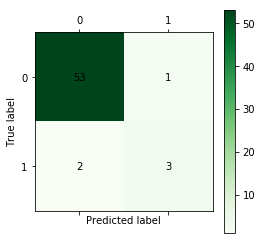

In [175]:
cm_plot(y_test, reg.predict(X_test)).show()

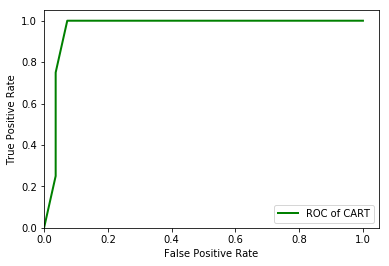

In [177]:
from sklearn.metrics import roc_curve  # 导入ROC曲线函数
fpr, tpr, thresholds = roc_curve(y_test, reg.predict_proba(X_test)[:, 1], pos_label=1)
plt.plot(fpr, tpr, linewidth=2, label='ROC of CART', color='green')  # 作出ROC曲线
plt.xlabel('False Positive Rate')  # 坐标轴标签
plt.ylabel('True Positive Rate')  # 坐标轴标签
plt.ylim(0, 1.05)  # 边界范围
plt.xlim(0, 1.05)  # 边界范围
plt.legend(loc=4)  # 图例
plt.show()  # 显示作图结果